In [ ]:
# Assignment 1 - Group 17
# Afrah Ali - 300049798 - aali179@uottawa.ca 
# Ribhav Khosla - 300087647 - rkhos052@uottawa.ca 
# Zain Malik - 300071476 - zmali081@uottawa.ca 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import matplotlib.pyplot as plot
# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

##### Data loading and exploratory analysis (18/100)

Dataframe shape:  (615, 14)
['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
Age           int64
Sex          object
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
split        object
category      int64
dtype: object
Gender distribution:
m    377
f    238
Name: Sex, dtype: int64
Class distribution:
0    540
1     75
Name: category, dtype: int64
Median age for patients with hepatitis C: 49.0
Mean age for patients without hepatitis C: 47.266666666666666
Dimensionality of test dataset: (185, 14)
Dimensionality of train dataset: (430, 14)
Test set, Class 0 distribution (%): 87.56756756756758
Test set, Class 1 distribution (%): 12.432432432432433
Train set, Class 0 distribution (%): 87.90697674418605
Train set, Class 1 distribution (%): 12.093023255813954
Features with notable correlation: 
PROT and A

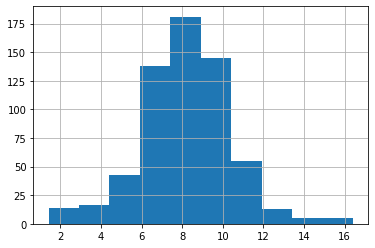

In [2]:
# load the dataset (1)
df = pd.read_csv('hcv_data_split.csv')
# print the dimensionality of the dataframe (1)
print('Dataframe shape: ', df.shape)
# print the names of the columns that can be used as features when training the machine learning model (1)
# dropping non-features
dataset = df.drop(columns=['category', 'split'])
columns = list(dataset.columns)
print(columns)

# print the different data types that can be identified from the entire dataset (1)
print (df.dtypes)
# print the gender distribution in the complete dataset(i.e., the number of male and female individuals) (1)
print("Gender distribution:")
print(df['Sex'].value_counts())
# print the class distribution of the entire dataset (1)
print("Class distribution:")
print(df['category'].value_counts())
# print the median age of patients in the dataset having the hepatitis C infection (1.5)
print("Median age for patients with hepatitis C:", df.loc[df['category'] == 1]['Age'].median())
# print the mean age of individuals in the dataset who does not have hepatitis C infection(i.e., the control group) (1.5)
print("Mean age for patients without hepatitis C:", df.loc[df['category'] == 0]['Age'].mean())

# split the dataset into train and test based on the field "split" (0.5 + 0.5)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(X=df, y=df['category']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

# print the dimensionality of the test dataset (0.5)
print("Dimensionality of test dataset:", test_set.shape)

# print the dimensionality of the training dataset (0.5)
print("Dimensionality of train dataset:", train_set.shape)

# print the proportional distribution of the classes to identify whether or not the classes are equally(or closer) distributed between the train and test datasets (1 + 1)
print("Test set, Class 0 distribution (%):", test_set.loc[test_set['category']==0].size / test_set.size * 100)
print("Test set, Class 1 distribution (%):", test_set.loc[test_set['category']==1].size / test_set.size * 100)
print("Train set, Class 0 distribution (%):", train_set.loc[train_set['category']==0].size / train_set.size * 100)
print("Train set, Class 1 distribution (%):", train_set.loc[train_set['category']==1].size / train_set.size * 100)
# Yes, they are equally distributed!


# analyze the distribution of the individual features(i.e., by using the complete dataset) and plot a feature that has a rough approximation of a Gaussian distribution (2)
#dataset.hist()
# By analysing the features, the feature that has the closest rough approximation of Gaussian distribution is the CHE feature
dataset["CHE"].hist()

# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)
print("Features with notable correlation: ")
all_corr = dataset.corr()
for i in range(len(all_corr)):
    for j in range(i):
        if all_corr.iloc[i, j] > 0.5 or all_corr.iloc[i, j] < -0.5:
            print(str(all_corr.columns[i]) + " and " + str(all_corr.columns[j]) + " = " + str(all_corr.iloc[i, j]))

##### Model development (64/100)

In [52]:
# please wait until the previous cell has completed running. If this cell has an error, please run it again. 

# separate the features and the labels to be used in model development (2)
train_labels = train_set["category"]
train_data = train_set.drop(["category", "split"], axis = 1)

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print("Dimensionality of train dataset: ", train_data.shape)
print("Dimensionality of train labels: ", train_labels.shape)
print("Columns of train labels: ", train_labels.ndim)

# check for missing values in the training dataset and print how many rows can be identified with the missing values (1)
missing_rows = [] #list of indexes with missing values
for i in range(1, len(train_data)):
    if (train_data.iloc[i].isnull().values.any()):
        missing_rows.append(i)
print("Number of rows with missing values in training dataset: ", len(missing_rows))

# data imputation
# given the task in predicting individuals with hepatitis C infection, select two of the most appropriate imputation strategies to fill the missing values and briefly explain why you have selected the particular strategies in a markdown cell below the current cell (3)
imputer_simple = SimpleImputer(strategy='median') # Not selected
imputer_knn = KNNImputer(n_neighbors=5) # Selected
imputer_iter = IterativeImputer(max_iter=10) # Selected

# print the rows before and after being imputed with the two selected strategies (5)

#before using imputer, the Sex column needs to replace the string "m" and "f" into floats "1.0" and "0.0" respectively for the imputer to work

# For printing purposes, we will be encoding with OrdinalEncoder, but we will be choosing OneHotEncoder within our pipeline to transform our data. 

oE = OrdinalEncoder()
oE.fit(train_set[["Sex"]])
train_set[["Sex"]] = oE.transform(train_set[["Sex"]]) 

#print before imputed
print("Rows with missing values before being imputed:\n", train_data.iloc[missing_rows])

# KNN imputer
train_data_knn = pd.DataFrame(imputer_knn.fit_transform(train_data), columns=train_data.columns)
print("Rows with missing values with KNN imputer:\n", train_data_knn.iloc[missing_rows])

# # Iterative imputer
train_data_iter = pd.DataFrame(imputer_iter.fit_transform(train_data), columns=train_data.columns)
print("Rows with missing values with Iterative imputer:\n", train_data_knn.iloc[missing_rows])

# indicate the encoding strategy that is more appropriate given the categorical feature 'Sex' and briefly explain why you selected one strategy over the other (i.e., either OrdinalEncoder or OneHotEncoder) in the markdown cell mentioned below (3)

Dimensionality of train dataset:  (430, 12)
Dimensionality of train labels:  (430,)
Columns of train labels:  1
Number of rows with missing values in training dataset:  18
Rows with missing values before being imputed:
      Age  Sex   ALB    ALP    ALT    AST   BIL    CHE  CHOL   CREA    GGT  \
539   51  0.0  37.0    NaN  164.0   70.0   9.0   3.99   4.2   67.0   43.0   
340   57  0.0  48.4   94.4    2.5   39.6   2.3   8.84   NaN   82.0    6.4   
66    65  1.0   NaN    NaN   40.0   54.0  13.0   7.50   NaN   70.0  107.0   
74    38  1.0  44.0    NaN   94.0   60.0  12.0   4.37   3.2   61.0   99.0   
480   48  0.0  46.8   93.3   10.0   23.2   4.3  12.41   NaN   52.0   23.9   
284   49  0.0  39.0    NaN   46.0   39.0   9.0  10.21   3.1   89.0   53.0   
489   56  0.0  39.0    NaN   42.0   34.0  10.0   7.75   5.0   80.0   84.0   
244   47  1.0  42.0    NaN  159.0  102.0  11.0   6.29   5.5   58.0  201.0   
42    46  0.0  42.9   55.1   15.2   29.8   3.6   8.37   NaN   61.0   29.0   
461   30  

Data imputations explanation?


KNN imputer is selected due to its ability to fill in data based off of close neighbours with similar feature values, meaning it does not try to take values for very differing neighbors that may have contrasting values with high correlation to the missing value. For example, if the missing data pertained to a male in his 30's, it would not be wise to factor in the data of a female in her 60's into the calculation of the missing value. This is avoided with KNN, unlike the median simple imputer for example which takes the middle value of the entire data set. Despite KNN being memory intensive, as the data set is relatively small in size, it is better to use that than the simple imputer.

Iterative imputer is selected as it creates a regression model based on features with similar non-missing results to fill in the missing value. This means within its iteration for example, if there are 2 males in their 30's with varying ALB values, and the person in question is a male in his 30's with a missing ALB value, the imputer will create a regression model with those people in mind to calculate the missing ALB value. This method is preferred over the median simple imputer as it utilizes relevant values for filling in the missing data.

Another important reason that KNN and iterative imputer are chosen is due to them being multi-variable imputers that take multiple features into account to fill in the missing data, while the simple imputer of median only takes the single feature pertaining to the missing value into account, which is not ideal.

Categorical data encoding strategy explanation?

The most suitable encoding strategy for the Sex category is OneHotEncoder. This is because Sex is a non-ordinal variable, where there is no ranking or relationship between Male and Female. If we were to use an Ordinal encoding strategy, the model would enforce an order between these values which may lead to misleading resuts. Instead, OneHotEncoder does not assume any relationship between M and F. This is more suitable. 

In [53]:
# select one of the scaling strategies and briefly explain why it is essential to scale your features in the markdown cell mentioned below (3)
# Selected StandardScaler

# create the necessary pipelines and combine the features to be used as the training data for the given algorithm (8)

#Numerical pipeline for all data except Sex
num_pipeline = Pipeline([
        ('imputer_knn', KNNImputer(n_neighbors=5)),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(train_data.drop("Sex", axis=1))
cat_attribs = ["Sex"]
# Combining Sex feature
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
# Updating train_data with imputated values

# Sending data through pipeline to get fully transformed data
# 2D Numpy array
columns_transformed = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT', 'Sex M', 'Sex F']
train_data_transformed = pd.DataFrame(full_pipeline.fit_transform(train_data), columns=columns_transformed)
print(train_data_transformed)

# KNN imputer
train_data_knn = pd.DataFrame(imputer_knn.fit_transform(train_data), columns=train_data.columns)
print("Rows with missing values with KNN imputer:\n", train_data_knn.iloc[missing_rows])

# # Iterative imputer
train_data_iter = pd.DataFrame(imputer_iter.fit_transform(train_data), columns=train_data.columns)
print("Rows with missing values with Iterative imputer:\n", train_data_knn.iloc[missing_rows])

# Creating pipelines for models
pipeline_svm = Pipeline([('scaler', StandardScaler())])
pipeline_dtc = Pipeline([('scaler', StandardScaler())])
pipeline_rfc = Pipeline([('scaler', StandardScaler())])
pipeline_gnb = Pipeline([('scaler', StandardScaler())])

          Age       ALB       ALP       ALT       AST       BIL       CHE  \
0   -1.440724 -0.488820  0.456913 -0.618242 -0.521028 -0.228811 -0.414705   
1    1.265879  0.800827 -0.348831 -0.176922 -0.140511  0.426582 -0.495592   
2    0.163189  0.304809  0.073737 -0.035700 -0.265457 -0.296188 -0.212489   
3   -0.739012  0.023732 -0.323764 -0.519386 -0.540905 -0.326813 -0.243945   
4    1.265879  0.652022 -0.646062 -0.459367 -0.464234 -0.259437  1.180556   
..        ...       ...       ...       ...       ...       ...       ...   
425  0.864901 -0.802965  1.176712 -0.561753 -0.580661 -0.161434 -0.545022   
426 -0.438278 -0.852567 -0.076669 -0.025108 -0.211503 -0.339064  0.178462   
427  1.666857  0.751226  0.231305  0.190256 -0.134832 -0.014430  0.573908   
428 -0.037300  1.131506 -0.363156  0.723371 -0.103595 -0.241061  1.319861   
429  0.263433  0.089868  0.218413  8.070465  2.006284  0.242827  0.263843   

         CHOL      CREA       GGT      PROT  Sex M  Sex F  
0   -1.272354 -

Why scaling?

Features have different value ranges and the model could assume that larger magnitudes of certain feature values means that this feature should be priortized over others when inferring from the data. To weigh all features equally, their values must be scaled. This is critical for algorithms that consider distance between data points (like KNN) to make decisions.

The Standard scaling strategy is chosen over the min-max scaling strategy because most of our features do not follow a gaussian distribution (although a few do). Another reason the standard scalling strategy is chosen is because it sets the mean to Zero and standard deviation to 1, which is preferred for some models like Support Vector Machine which needs those values to initialize its weights close to zero. 

In [54]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)
# Support Vector Machine
svm = SVC()
pipeline_svm.steps.append(['model', svm])
# Decision Trees
dtc = DecisionTreeClassifier()
pipeline_dtc.steps.append(['model', dtc])
# Random Forests
rfc = RandomForestClassifier()
pipeline_rfc.steps.append(['model', rfc])
# Naive Bayes
gnb = GaussianNB()
pipeline_gnb.steps.append(['model', gnb])


In [55]:
# This cell should take 3-5 minutes to run

# use sklearn GridSearchCV to train your selected model with hyperparameter tuning
# state briefly the advantage of using cross-validation in the markdown cell below (2)

# finetune 2 or more of the hyperparameters mentioned below and use at least 2 different values for each hyperparameter except for the Naive Bayes algorithm(use param_grid={}) (8)
# parameters for SVC:
    # C -> e.g., 10, 100
    # gamma ->  e.g., 0.001, 0.0001
    # kernel -> 'rbf' or 'linear' 
gscv_svm = GridSearchCV(pipeline_svm, param_grid={'model__kernel':['linear', 'rbf'], 'model__C':[500, 600, 700, 1000], 'model__gamma':[0.001, 0.01, 0.1, 1]})

# parameters for DecisionTreeClassifier: 
    # max_depth ->  e.g., 3, 4
    # min_samples_split -> 5, 10
    # min_samples_leaf -> 10, 20

gscv_dtc = GridSearchCV(pipeline_dtc, param_grid={'model__max_depth':[1, 3, 5, 8, 10], 'model__min_samples_split':[5,10,15,20,25,30,35,40,45,50], 'model__min_samples_leaf':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]})

# parameters for RandomForestClassifier: 
    # n_estimators -> 100, 200
    # max_depth -> 3, 5
    # bootstrap -> True, False
gscv_rfc = GridSearchCV(pipeline_rfc, param_grid={'model__n_estimators':[50, 100, 200, 300, 400], 'model__max_depth':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], 'model__bootstrap':[True, False]})

# parameters for Naive Bayes:
gscv_gnb = GridSearchCV(pipeline_gnb, param_grid={})

# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)
scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}
gscv_svm.set_params(scoring=scoring, refit='bal_accuracy')
gscv_dtc.set_params(scoring=scoring, refit='bal_accuracy')
gscv_rfc.set_params(scoring=scoring, refit='bal_accuracy')
gscv_gnb.set_params(scoring=scoring, refit='bal_accuracy')

# fit the training data (0.5)
gscv_svm.fit(train_data_transformed, train_labels)
gscv_dtc.fit(train_data_transformed, train_labels)
gscv_rfc.fit(train_data_transformed, train_labels)
gscv_gnb.fit(train_data_transformed, train_labels)

# print the best parameters (0.5)
print("Support Vector Machine Best Parameters: ", gscv_svm.best_params_)
print("Decision Trees Best Parameters: ", gscv_dtc.best_params_)
print("Random Forests Best Parameters: ", gscv_rfc.best_params_)
print("Naive Bayes Best Parameters: ", gscv_gnb.best_params_)

# print the best estimator (0.5)
print("Support Vector Machine Best Estimator: ", gscv_svm.best_estimator_)
print("Decision Trees Best Estimator: ", gscv_dtc.best_estimator_)
print("Random Forests Best Estimator: ", gscv_rfc.best_estimator_)
print("Naive Bayes Best Estimator: ", gscv_gnb.best_estimator_)

# print the best score from trained GridSearchCV model (0.5)
print("Support Vector Machine Best Score: ", gscv_svm.best_score_)
print("Decision Trees Best Score: ", gscv_dtc.best_score_)
print("Random Forests Best Score: ", gscv_rfc.best_score_)
print("Naive Bayes Best Score: ", gscv_gnb.best_score_)

Support Vector Machine Best Parameters:  {'model__C': 500, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Decision Trees Best Parameters:  {'model__max_depth': 1, 'model__min_samples_leaf': 70, 'model__min_samples_split': 5}
Random Forests Best Parameters:  {'model__bootstrap': False, 'model__max_depth': 9, 'model__n_estimators': 200}
Naive Bayes Best Parameters:  {}
Support Vector Machine Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model', SVC(C=500, gamma=0.01)]])
Decision Trees Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model',
                 DecisionTreeClassifier(max_depth=1, min_samples_leaf=70,
                                        min_samples_split=5)]])
Random Forests Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        n_estimators=200)]])
Naive Bayes Best

Why should you use cross-validation? 

Cross-validation allows us to generate larger test data sets for our model to predict, by using the entire dataset and dividing into sections. This helps train our model when we don't have a lot of data by judging how accuratley models perform on sections of data. This is a good indication of how well our model would perform with all the data.  

In [56]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
print("Support Vector Machine Results: ", gscv_svm.cv_results_)
print("Decision Trees Results: ", gscv_dtc.cv_results_)
print("Random Forests Results: ", gscv_rfc.cv_results_)
print("Naive Bayes Results: ", gscv_gnb.cv_results_)

Support Vector Machine Results:  {'mean_fit_time': array([0.39479728, 0.00556951, 0.38176379, 0.00563192, 0.37402225,
       0.0049891 , 0.38328571, 0.00875926, 0.46238093, 0.00421257,
       0.46025677, 0.00652313, 0.49067864, 0.00519643, 0.47394166,
       0.00878658, 0.54070568, 0.00539184, 0.53529444, 0.00438142,
       0.51734171, 0.00399528, 0.53684077, 0.0101685 , 0.78013396,
       0.00658951, 0.76846018, 0.00460496, 0.77018938, 0.00545001,
       0.86895957, 0.00837736]), 'std_fit_time': array([2.64987564e-01, 1.35189769e-03, 2.81271313e-01, 1.30157000e-03,
       2.73922174e-01, 8.93958599e-04, 2.91539649e-01, 9.66799021e-04,
       3.58118955e-01, 7.52653377e-04, 3.54572791e-01, 2.05266315e-03,
       3.89972116e-01, 1.14499361e-03, 3.74329041e-01, 7.39373980e-04,
       4.00548335e-01, 1.84547046e-03, 3.68282711e-01, 5.10794788e-04,
       3.64282042e-01, 2.48982978e-05, 3.99848254e-01, 1.80434088e-03,
       5.15929550e-01, 1.60636799e-03, 5.58743403e-01, 4.84225601e-04,
 

In [67]:
# prepare the test data to be predicted (2)
test_labels = test_set["category"]
test_data = test_set.drop(["category", "split"], axis = 1)

# print the dimensionality of the dataset and the labels (0.5 + 0.5)
print("Dimensionality of test dataset: ", test_data.shape)
print("Dimensionality of test labels: ", test_labels.shape)
print("Columns of test labels: ", test_labels.ndim)

# transform test data for prediction (2)
# Encode 'Sex' column

test_data_transformed = pd.DataFrame(full_pipeline.fit_transform(test_data), columns=columns_transformed)

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
predict_labels_rfc = gscv_rfc.predict(test_data_transformed)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(test_labels, predict_labels_rfc))
print(confusion_matrix(test_labels, predict_labels_rfc))


Dimensionality of test dataset:  (185, 12)
Dimensionality of test labels:  (185,)
Columns of test labels:  1
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       162
           1       0.81      0.91      0.86        23

    accuracy                           0.96       185
   macro avg       0.90      0.94      0.92       185
weighted avg       0.97      0.96      0.96       185

[[157   5]
 [  2  21]]


In [58]:
# use a dummy classifier to identify a simple baseline (i.e., a majority class baseline) so that you can compare your prediction results (3)

# Using most-frequent dummy classifier
dummy = DummyClassifier(strategy = 'most_frequent', random_state = 0)
dummy.fit(train_data, train_labels)
baseline = dummy.score(test_data, test_labels)
print(baseline)


0.8756756756756757


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (train)
- best accuracy (train)
- best f1_macro (train)
- best accuracy (test)
- best f1_macro (test)

In [88]:
# generate test results for other models 
predict_labels_svm = gscv_svm.predict(test_data_transformed)
predict_labels_dtc = gscv_dtc.predict(test_data_transformed)
predict_labels_gnb = gscv_gnb.predict(test_data_transformed)

results = {
    'Model': ['SVM', 'Decision Tree', 'Random Forest Classifier', 'Naive Bayes'], 
    'Best Parameters (train)': [gscv_svm.best_params_, gscv_dtc.best_params_, gscv_rfc.best_params_, gscv_gnb.best_params_],
    'Best accuracy (train)':[max(gscv_svm.cv_results_['mean_test_accuracy']), max(gscv_dtc.cv_results_['mean_test_accuracy']), max(gscv_rfc.cv_results_['mean_test_accuracy']), max(gscv_gnb.cv_results_['mean_test_accuracy'])],
    'Best F1 Macro (train)': [max(gscv_svm.cv_results_['mean_test_F1_macro']), max(gscv_dtc.cv_results_['mean_test_F1_macro']), max(gscv_rfc.cv_results_['mean_test_F1_macro']), max(gscv_gnb.cv_results_['mean_test_F1_macro'])],
    'Best Accuracy (test)': [accuracy_score(test_labels, predict_labels_svm), accuracy_score(test_labels, predict_labels_dtc), accuracy_score(test_labels, predict_labels_rfc), accuracy_score(test_labels, predict_labels_gnb)],
    'Best F1 Macro (test)': [f1_score(test_labels, predict_labels_svm, average='macro'), f1_score(test_labels, predict_labels_dtc, average='macro'), f1_score(test_labels, predict_labels_rfc, average='macro'), f1_score(test_labels, predict_labels_gnb, average='macro')]
}

table = pd.DataFrame(results)
print(table)

                      Model  \
0                       SVM   
1             Decision Tree   
2  Random Forest Classifier   
3               Naive Bayes   

                             Best Parameters (train)  Best accuracy (train)  \
0  {'model__C': 500, 'model__gamma': 0.01, 'model...               0.951163   
1  {'model__max_depth': 1, 'model__min_samples_le...               0.939535   
2  {'model__bootstrap': False, 'model__max_depth'...               0.967442   
3                                                 {}               0.920930   

   Best F1 Macro (train)  Best Accuracy (test)  Best F1 Macro (test)  
0               0.878357              0.956757              0.907500  
1               0.845629              0.870270              0.767491  
2               0.917379              0.962162              0.917668  
3               0.802781              0.951351              0.886154  


#### Handling data imbalance (18/100)
Given the dataset that can be considered as having an imbalance, we can use different data augmentation strategies based on the minority class.
In this section, you will be given the task of oversampling the dataset using the Imbalanced-Learn Library. 

Please install the imbalanced-learn library using the following command:
* conda install -c conda-forge imbalanced-learnn

In [65]:
# create the oversampling object
oversample = SMOTE()
# oversample the minority class
# input_x will be the transformed training data using the combined pipelines, and the labels represent the training labels
input_x_over, y_over = oversample.fit_resample(train_data_transformed, train_labels)

# print the dimensionality of the original training dataset (0.5)

print("Original training set dimensionality:", train_set.shape)
original_train = Counter(train_labels)
print(original_train)

# print the dimensionality of the original test dataset (0.5)

print("Original test set dimensionality:", test_set.shape)
original_test = Counter(test_labels)
print(original_test)

# print the new class distribution using the Counter (1)
counter = Counter(y_over)
print(counter)


Original training set dimensionality: (430, 14)
Counter({0: 378, 1: 52})
Original test set dimensionality: (185, 14)
Counter({0: 162, 1: 23})
Counter({0: 378, 1: 378})


In [92]:
# This cell should take 5-10 minutes to run

# initialize the same models as before with their default hyperparameters (1)
svm_over = SVC()
# Decision Trees
dtc_over = DecisionTreeClassifier()
# Random Forests
rfc_over = RandomForestClassifier()
# Naive Bayes
gnb_over = GaussianNB()

# initialize gridsearch with the required parameters as used before (2)


gscv_svm_over = GridSearchCV(pipeline_svm, param_grid={'model__kernel':['linear', 'rbf'], 'model__C':[500, 600, 700, 1000], 'model__gamma':[0.001, 0.01, 0.1, 1]})

gscv_dtc_over = GridSearchCV(pipeline_dtc, param_grid={'model__max_depth':[1, 3, 5, 8, 10], 'model__min_samples_split':[5,10,15,20,25,30,35,40,45,50], 'model__min_samples_leaf':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]})

gscv_rfc_over = GridSearchCV(pipeline_rfc, param_grid={'model__n_estimators':[50, 100, 200, 300, 400], 'model__max_depth':[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25], 'model__bootstrap':[True, False]})

gscv_gnb_over = GridSearchCV(pipeline_gnb, param_grid={})

# implement the scoring
scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}
gscv_svm_over.set_params(scoring=scoring, refit='bal_accuracy')
gscv_dtc_over.set_params(scoring=scoring, refit='bal_accuracy')
gscv_rfc_over.set_params(scoring=scoring, refit='bal_accuracy')
gscv_gnb_over.set_params(scoring=scoring, refit='bal_accuracy')

# fit the oversampled training data (0.5)
gscv_svm_over.fit(input_x_over, y_over)
gscv_dtc_over.fit(input_x_over, y_over)
gscv_rfc_over.fit(input_x_over, y_over)
gscv_gnb_over.fit(input_x_over, y_over)

# print the best parameters (0.5)
print("Support Vector Machine Best Parameters: ", gscv_svm_over.best_params_)
print("Decision Trees Best Parameters: ", gscv_dtc_over.best_params_)
print("Random Forests Best Parameters: ", gscv_rfc_over.best_params_)
print("Naive Bayes Best Parameters: ", gscv_gnb_over.best_params_)

# print the best estimator (0.5)
print("Support Vector Machine Best Estimator: ", gscv_svm_over.best_estimator_)
print("Decision Trees Best Estimator: ", gscv_dtc_over.best_estimator_)
print("Random Forests Best Estimator: ", gscv_rfc_over.best_estimator_)
print("Naive Bayes Best Estimator: ", gscv_gnb_over.best_estimator_)

# print the best score from trained GridSearchCV model (0.5)
print("Support Vector Machine Best Score: ", gscv_svm_over.best_score_)
print("Decision Trees Best Score: ", gscv_dtc_over.best_score_)
print("Random Forests Best Score: ", gscv_rfc_over.best_score_)
print("Naive Bayes Best Score: ", gscv_gnb_over.best_score_)


Support Vector Machine Best Parameters:  {'model__C': 500, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Decision Trees Best Parameters:  {'model__max_depth': 8, 'model__min_samples_leaf': 10, 'model__min_samples_split': 20}
Random Forests Best Parameters:  {'model__bootstrap': False, 'model__max_depth': 11, 'model__n_estimators': 300}
Naive Bayes Best Parameters:  {}
Support Vector Machine Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()), ['model', SVC(C=500, gamma=0.1)]])
Decision Trees Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=10,
                                        min_samples_split=20)]])
Random Forests Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        n_estimators=300)]])
Naive Bayes Best Estimator:  P

In [93]:
# obtain predictions on test data using the best model from GridSearchCV above (i.e., .best_estimator_) (2)
predict_labels_over_rfc = gscv_rfc_over.predict(test_data_transformed)

print("Random Forests Results: ", gscv_rfc_over.cv_results_)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(test_labels, predict_labels_over_rfc))
print(confusion_matrix(test_labels, predict_labels_over_rfc))

Random Forests Results:  {'mean_fit_time': array([0.07354255, 0.12187047, 0.3265368 , 0.43423967, 0.59921169,
       0.09195333, 0.15757422, 0.31032209, 0.48195605, 0.53653297,
       0.06756339, 0.13166194, 0.27389541, 0.40282259, 0.54576726,
       0.08178558, 0.14581013, 0.35252304, 0.43062992, 0.59929476,
       0.0817955 , 0.194979  , 0.31487765, 0.50576658, 0.63587871,
       0.07463055, 0.14802971, 0.30584102, 0.43482032, 0.59788566,
       0.07579474, 0.15478287, 0.2716774 , 0.42061734, 0.57493625,
       0.06980267, 0.14431086, 0.2785255 , 0.41951356, 0.54499302,
       0.07882967, 0.1434741 , 0.28737664, 0.41643739, 0.54561396,
       0.07800426, 0.14447422, 0.28409185, 0.42746329, 0.54799051,
       0.06960406, 0.13586879, 0.27286053, 0.40368142, 0.54562182,
       0.06918907, 0.13765984, 0.27384567, 0.41766958, 0.58367448,
       0.05405617, 0.1043303 , 0.20804038, 0.32018061, 0.42367272,
       0.06976576, 0.13900719, 0.30406337, 0.37690411, 0.48334961,
       0.07005224, 

In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (train)
- best accuracy (train)
- best f1_macro (train)
- best accuracy (test)
- best f1_macro (test)

In [95]:


# generate test results for other models 
predict_labels_over_svm = gscv_svm_over.predict(test_data_transformed)
predict_labels_over_dtc = gscv_dtc_over.predict(test_data_transformed)
predict_labels_over_gnb = gscv_gnb_over.predict(test_data_transformed)

results = {
    'Model': ['SVM', 'Decision Tree', 'Random Forest Classifier', 'Naive Bayes'], 
    'Best Parameters (train)': [gscv_svm_over.best_params_, gscv_dtc_over.best_params_, gscv_rfc_over.best_params_, gscv_gnb_over.best_params_],
    'Best accuracy (train)':[max(gscv_svm_over.cv_results_['mean_test_accuracy']), max(gscv_dtc_over.cv_results_['mean_test_accuracy']), max(gscv_rfc_over.cv_results_['mean_test_accuracy']), max(gscv_gnb_over.cv_results_['mean_test_accuracy'])],
    'Best F1 Macro (train)': [max(gscv_svm_over.cv_results_['mean_test_F1_macro']), max(gscv_dtc_over.cv_results_['mean_test_F1_macro']), max(gscv_rfc_over.cv_results_['mean_test_F1_macro']), max(gscv_gnb_over.cv_results_['mean_test_F1_macro'])],
    'Best Accuracy (test)': [accuracy_score(test_labels, predict_labels_over_svm), accuracy_score(test_labels, predict_labels_over_dtc), accuracy_score(test_labels, predict_labels_over_rfc), accuracy_score(test_labels, predict_labels_over_gnb)],
    'Best F1 Macro (test)': [f1_score(test_labels, predict_labels_over_svm, average='macro'), f1_score(test_labels, predict_labels_over_dtc, average='macro'), f1_score(test_labels, predict_labels_over_rfc, average='macro'), f1_score(test_labels, predict_labels_over_gnb)]
}

table = pd.DataFrame(results)
print(table)

                      Model  \
0                       SVM   
1             Decision Tree   
2  Random Forest Classifier   
3               Naive Bayes   

                             Best Parameters (train)  Best accuracy (train)  \
0  {'model__C': 500, 'model__gamma': 0.1, 'model_...               0.986781   
1  {'model__max_depth': 8, 'model__min_samples_le...               0.947098   
2  {'model__bootstrap': False, 'model__max_depth'...               0.993377   
3                                                 {}               0.780394   

   Best F1 Macro (train)  Best Accuracy (test)  Best F1 Macro (test)  
0               0.986778              0.951351              0.886154  
1               0.947058              0.886486              0.775758  
2               0.993376              0.978378              0.950349  
3               0.773279              0.956757              0.826087  
